# Quantitative Structure-Activity Relationship of Fish Toxicity

This project aims to analyze the quantitative structure-activity relationship to predict acute aquatic toxicity towards the fish Pimephales promelas (fathead minnow) on a set of 908 chemicals. The method used is k-Nearest Neighbor (KNN).

***
Variables used are:

* CIC0 : Complementary Information Content index (neighborhood symmetry of 0-order)
* SM1_Dz(Z) : Spectral moment of order 1 from Barysz matrix weighted by atomic number
* GATS1i : Geary autocorrelation of lag 1 weighted by ionization potential
* NdsCH : Number of atoms of type dsCH
* NdssC : Number of atoms of type dssC
* MLOGP : Moriguchi octanol-water partition coeff. (logP)
* Target variables, LC50 \[-LOG(mol/L)] : The exposure concentration of a toxic substance lethal to half of the test animals

***

Dataset source : https://archive.ics.uci.edu/ml/datasets/QSAR+fish+toxicity

## Project Preparation

Import libraries

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
plt.style.use("fivethirtyeight")

Load the dataset

In [2]:
dataset = pd.read_csv("dataset/qsar_fish_toxicity.csv")
dataset.head(10)

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,LC50 [-LOG(mol/L)]
0,3.260,0.829,1.676,0,1,1.453,3.770
1,2.189,0.580,0.863,0,0,1.348,3.115
2,2.125,0.638,0.831,0,0,1.348,3.531
3,3.027,0.331,1.472,1,0,1.807,3.510
4,2.094,0.827,0.860,0,0,1.886,5.390
5,3.222,0.331,2.177,0,0,0.706,1.819
6,3.179,0.000,1.063,0,0,2.942,3.947
7,3.000,0.000,0.938,1,0,2.851,3.513
8,2.620,0.499,0.990,0,0,2.942,4.402
9,2.834,0.134,0.950,0,0,1.591,3.021


## Data Summarization and Visualization

Shows the summary of the data

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CIC0                908 non-null    float64
 1   SM1_Dz(Z)           908 non-null    float64
 2   GATS1i              908 non-null    float64
 3   NdsCH               908 non-null    int64  
 4   NdssC               908 non-null    int64  
 5   MLOGP               908 non-null    float64
 6   LC50 [-LOG(mol/L)]  908 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 49.8 KB


It can be seen that there's no missing values in this dataset, and all variables are in numeric values

Generate the descriptive statistics of the dataset

In [4]:
dataset.describe()

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,LC50 [-LOG(mol/L)]
count,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000
mean,2.898129,0.628468,1.293591,0.229075,0.485683,2.109285,4.064431
std,0.756088,0.428459,0.394303,0.605335,0.861279,1.433181,1.455698
min,0.667000,0.000000,0.396000,0.000000,0.000000,-2.884000,0.053000
25%,2.347000,0.223000,0.950750,0.000000,0.000000,1.209000,3.151750
50%,2.934000,0.570000,1.240500,0.000000,0.000000,2.127000,3.987500
75%,3.407000,0.892750,1.562250,0.000000,1.000000,3.105000,4.907500
max,5.926000,2.171000,2.920000,4.000000,6.000000,6.515000,9.612000


Calculate the correlation of each columns with the LC50

In [5]:
dataset.corr(method="pearson")

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,LC50 [-LOG(mol/L)]
CIC0,1.000000,-0.235360,0.147622,0.121341,0.246639,0.463867,0.291854
SM1_Dz(Z),-0.235360,1.000000,-0.145967,-0.141401,0.163179,0.200663,0.410893
GATS1i,0.147622,-0.145967,1.000000,-0.010657,0.092410,-0.450739,-0.397965
NdsCH,0.121341,-0.141401,-0.010657,1.000000,0.188164,0.048620,0.172004
NdssC,0.246639,0.163179,0.092410,0.188164,1.000000,0.028499,0.172390
MLOGP,0.463867,0.200663,-0.450739,0.048620,0.028499,1.000000,0.651664
LC50 [-LOG(mol/L)],0.291854,0.410893,-0.397965,0.172004,0.172390,0.651664,1.000000


From the correlation test to the LC50 that has been done above, it is known that MLOGP has the highest correlation of 0.652 and GATS1i has the lowest correlation of -0.398.

Show the histogram plot of each variables

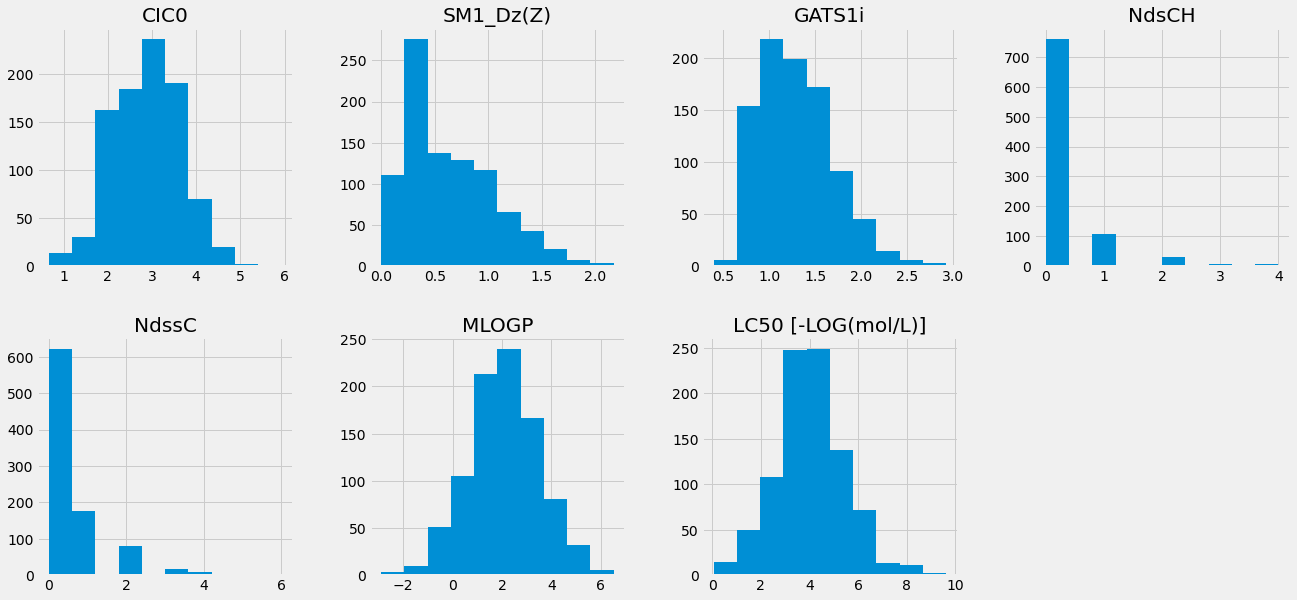

In [6]:
dataset.hist(figsize=(20, 20), layout=(4, 4));

## Data Preparation

Split the target and features in the dataset

In [7]:
X = dataset.drop(["LC50 [-LOG(mol/L)]"], axis=1)
y = pd.DataFrame(dataset["LC50 [-LOG(mol/L)]"].copy())

Split the dataset into training and testing set

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

Scales the features using Standard Scaler

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Model Training

Select the best k value for the KNN model

In [10]:
knn_result = []

for k in range (2, 10):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    knn_result.append(knn.score(X_train, y_train))
    print(f"R-Squared for k = {k} : {knn.score(X_train, y_train):.3f}")

R-Squared for k = 2 : 0.863
R-Squared for k = 3 : 0.798
R-Squared for k = 4 : 0.764
R-Squared for k = 5 : 0.753
R-Squared for k = 6 : 0.738
R-Squared for k = 7 : 0.722
R-Squared for k = 8 : 0.710
R-Squared for k = 9 : 0.706


Visualize the R-Squared result

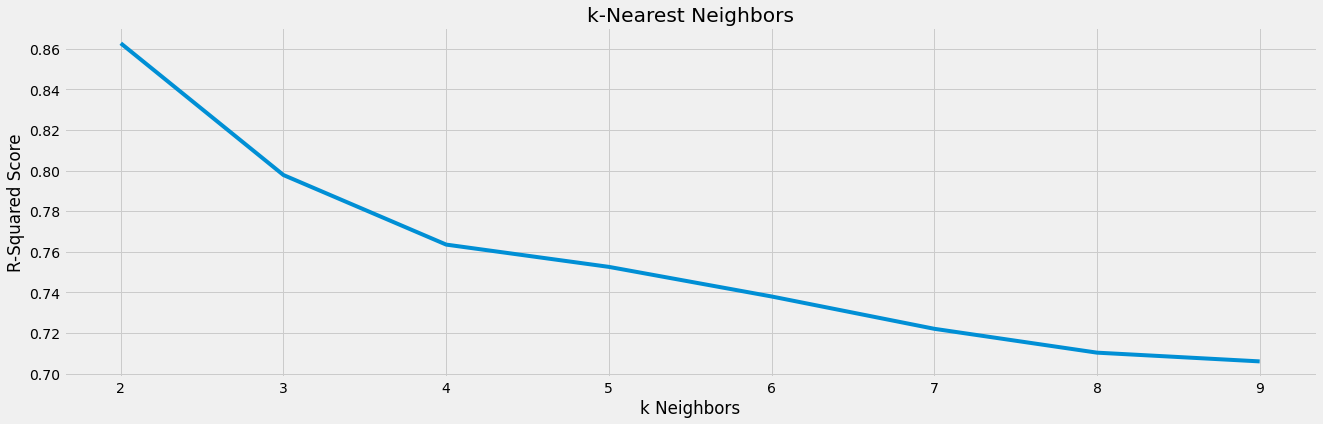

In [11]:
plt.figure(figsize=(20,6))
plt.plot([i for i in range(2, 10)], knn_result)
plt.xlabel("k Neighbors")
plt.ylabel("R-Squared Score")
plt.title("k-Nearest Neighbors")
plt.show()

It can be seen that the R-Squared value decreases with the increase of k used. The best R-Squared is obtained at the k=2, which will then be used to make the KNN model.

Create a KNN model and evaluate the model on the training set

In [12]:
knn = KNeighborsRegressor(n_neighbors=2).fit(X_train,y_train)
knn_training_pred = knn.predict(X_train)
knn_training_rsq = knn.score(X_train, y_train)
knn_training_rmse = np.sqrt(mean_squared_error(y_train, knn_training_pred))

print(f"R-Squared for the training set : {knn_training_rsq:.3f}")
print(f"RMSE for the training set : {knn_training_rmse:.3f}")

R-Squared for the training set : 0.863
RMSE for the training set : 0.529


Evaluate the model on the testing set

In [13]:
knn_testing_pred = knn.predict(X_test)
knn_testing_rsq = knn.score(X_test, y_test)
knn_testing_rmse = np.sqrt(mean_squared_error(y_test, knn_testing_pred))

print(f"R-Squared for the testing set : {knn_testing_rsq:.3f}")
print(f"RMSE for the testing set : {knn_testing_rmse:.3f}")

R-Squared for the testing set : 0.524
RMSE for the testing set : 1.073


Visualize the regression plot and the residual plot of the KNN method

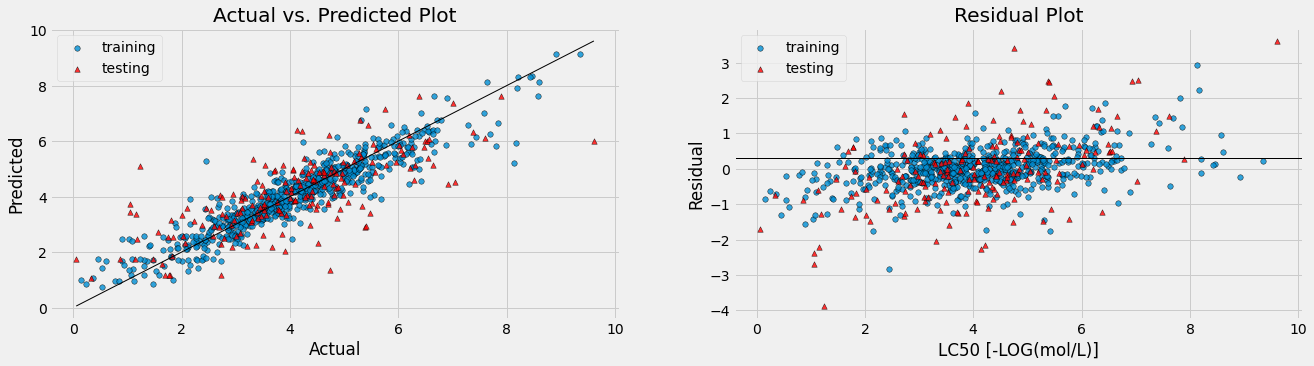

In [14]:
residual_train = y_train - knn_training_pred
residual_test = y_test - knn_testing_pred

fig=plt.figure(figsize=(20,5))

ax1=plt.subplot(1,2,1)
ax1.scatter(y_train, knn_training_pred, s=30, alpha=0.8, edgecolor="black", label="training")
ax1.scatter(y_test, knn_testing_pred, marker="^", s=30, c="r", alpha=0.8, edgecolor="black", label="testing")
ax1.plot([y.min(), y.max()], [y.min(), y.max()], "k", lw=1)
ax1.set_title("Actual vs. Predicted Plot")
ax1.set_xlabel("Actual")
ax1.set_ylabel("Predicted")
ax1.legend()

ax2=plt.subplot(1,2,2)
ax2.scatter(y_train, residual_train, s=30, alpha=0.8, edgecolor="black", label="training")
ax2.scatter(y_test, residual_test, marker="^", s=30, c="r", alpha=0.8, edgecolor="black", label="testing")
ax2.axhline(y=0.3, linewidth= 1, linestyle="-", c="black")
ax2.legend()
ax2.set_title("Residual Plot")
ax2.set_xlabel("LC50 [-LOG(mol/L)]")
ax2.set_ylabel("Residual")

plt.show()

## Save the Final Model

In [15]:
filename = "dataset/qsar_fish_toxicity_model.sav"
joblib.dump(knn, filename)

['dataset/qsar_fish_toxicity_model.sav']

## Conclusion

The KNN model to predict acute aquatic toxicity towards the fish Pimephales promelas (fathead minnow) has been successfully developed. In the parameter tuning process, the best k is 2. Based on the model evaluation results, it is known that the model has succeeded in obtaining good R-Squared and RMSE values in the training set, but the results obtained in the testing set are not good enough.